# Preprocessing for complex PDF

## Setting
 - Auto Reload
 - path for utils

In [223]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../../.."
add_python_path(module_path)

python path: /home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr already exists
sys.path:  ['/home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/02_qa_chatbot/01_preprocess_docs', '/home/ec2-user/anaconda3/envs/python3/lib/python310.zip', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/lib-dynload', '', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages', '/home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr']


## 1. Bedrock Client 생성

In [225]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [226]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [227]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [228]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7fb27039fac0>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7fb2721c8d00>])

### Embedding 모델 선택

In [229]:
from langchain.embeddings import BedrockEmbeddings

In [230]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. 데이터 준비 
- https://python.langchain.com/docs/integrations/document_loaders/unstructured_file
- cleansing: https://unstructured-io.github.io/unstructured/core/cleaning.html

### Extract Text, Table and Image from documents

In [231]:
from unstructured.cleaners.core import clean_bullets, clean_extra_whitespace
from langchain_community.document_loaders import UnstructuredFileLoader, UnstructuredAPIFileLoader

Parameters
----------
- filename
    - A string defining the target filename path.
- content_type
    - A string defining the file content in MIME type
- file
    - A file-like object using "rb" mode --> open(filename, "rb").
- metadata_filename
    - When file is not None, the filename (string) to store in element metadata. E.g. "foo.txt"
- url
    - The url for a remote document. Pass in content_type if you want partition to treat the document as a specific content_type.
- include_page_breaks
    - If True, the output will include page breaks if the filetype supports it
- strategy
    - The strategy to use for partitioning PDF/image. Uses a layout detection model if set to 'hi_res', otherwise partition simply extracts the text from the document and processes it.
- encoding
    - The encoding method used to decode the text input. If None, utf-8 will be used.
- headers
    - The headers to be used in conjunction with the HTTP request if URL is set.
- skip_infer_table_types
    - The document types that you want to skip table extraction with.
- ssl_verify
    - If the URL parameter is set, determines whether or not partition uses SSL verification in the HTTP request.
- languages
    - The languages present in the document, for use in partitioning and/or OCR. For partitioning <BR>
    image or pdf documents with Tesseract, you'll first need to install the appropriate <BR>
    Tesseract language pack. For other partitions, language is detected using naive Bayesian <BR>
    filter via `langdetect`. Multiple languages indicates text could be in either language. <BR>
    Additional Parameters: <BR>
        - detect_language_per_element <BR>
            - Detect language per element instead of at the document level.
    
- pdf_infer_table_structure
    - If True and strategy=hi_res, any Table Elements extracted from a PDF will include an
    additional metadata field, "text_as_html," where the value (string) is a just a
    transformation of the data into an HTML <table>.
    The "text" field for a partitioned Table Element is always present, whether True or False.
- extract_images_in_pdf
    - Only applicable if `strategy=hi_res`.
    If True, any detected images will be saved in the path specified by
    'extract_image_block_output_dir' or stored as base64 encoded data within metadata fields.
    Deprecation Note: This parameter is marked for deprecation. Future versions will use
    'extract_image_block_types' for broader extraction capabilities.
- extract_image_block_types
    - Only applicable if `strategy=hi_res`.
    Images of the element type(s) specified in this list (e.g., ["Image", "Table"]) will be
    saved in the path specified by 'extract_image_block_output_dir' or stored as base64
    encoded data within metadata fields.
- extract_image_block_to_payload
    - Only applicable if `strategy=hi_res`.
    If True, images of the element type(s) defined in 'extract_image_block_types' will be
    encoded as base64 data and stored in two metadata fields: 'image_base64' and
    'image_mime_type'.
    This parameter facilitates the inclusion of element data directly within the payload,
    especially for web-based applications or APIs.
- extract_image_block_output_dir
    - Only applicable if `strategy=hi_res` and `extract_image_block_to_payload=False`.
    The filesystem path for saving images of the element type(s)
    specified in 'extract_image_block_types'.
- xml_keep_tags
    - If True, will retain the XML tags in the output. Otherwise it will simply extract
    the text from within the tags. Only applies to partition_xml.
- request_timeout
    - The timeout for the HTTP request if URL is set. Defaults to None meaning no timeout and
    requests will block indefinitely.
- hi_res_model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`.
- model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`. To be
    deprecated in favor of `hi_res_model_name`.

In [232]:
image_path = "./fig"

loader = UnstructuredFileLoader(
    #file_path="./data/complex_pdf/sample.pdf",
    file_path="./data/complex_pdf/text2.pdf",

    chunking_strategy = "by_title",
    mode="elements",

    strategy="hi_res",
    hi_res_model_name="yolox",

    extract_images_in_pdf=True,
    #skip_infer_table_types='[]',
    pdf_infer_table_structure=False,

    extract_image_block_output_dir=image_path,
    extract_image_block_to_payload=False, ## to save image

    post_processors=[clean_bullets, clean_extra_whitespace]
)

In [233]:
# import mimetypes
# import requests
# import time

# api_key = "llx-R4G3Pzu5IZIdq5AoAFILW1PPaVZxrVRN937R6f3cItBvPs1U"

# headers = {"Authorization": f"Bearer {api_key}"}
# file_path = "./data/complex_pdf/sample.pdf"
# base_url = "https://api.cloud.llamaindex.ai/api/parsing"

# with open(file_path, "rb") as f:
#     mime_type = mimetypes.guess_type(file_path)[0]
#     files = {"file": (f.name, f, mime_type)}

#     # send the request, upload the file
#     url = f"{base_url}/upload"
#     response = requests.post(url, headers=headers, files=files)

# response.raise_for_status()
# # get the job id for the result_url
# job_id = response.json()["id"]
# result_type = "markdown"  # or "markdown"
# result_url = f"{base_url}/job/{job_id}/result/{result_type}"

# # check for the result until its ready
# while True:
#     response = requests.get(result_url, headers=headers)
#     if response.status_code == 200:
#         break

#     time.sleep(2)

# # download the result
# result = response.json()
# output = result[result_type]

In [234]:
# output.split("###")

In [235]:
%%time
docs = loader.load()

CPU times: user 2min 26s, sys: 359 ms, total: 2min 26s
Wall time: 2min 48s


In [236]:
tables, texts = [], []

for doc in docs:

    category = doc.metadata["category"]

    if category == "Table": tables.append(doc)
    elif category == "Image": images.append(doc)
    else: texts.append(doc)

images = glob(os.path.join(image_path, "*"))

print (f' # texts: {len(texts)} \n # tables: {len(tables)} \n # images: {len(images)}')

 # texts: 53 
 # tables: 28 
 # images: 59


In [237]:
docs

[Document(page_content='제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제제3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333 장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장장 ▼ ▼ ▼ 산업안전보건법 일반 ▼ ▼ ▼ 제3장 산업안전보건법 일반 1 산업안전보건법 개요 1 산업안전보건법 개요 ■ 산업안전보건법 ○ 산업안전보건법령은 고용노동부 소관 법령으로서 1개 법률, 1개 시행령, 3개 시행 규칙으로 구성되어 있다.', metadata={'source': './data/complex_pdf/text2.pdf', 'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2024-03-15T07:48:53', 'page_number': 1, 'file_directory': './data/complex_pdf', 'filename': 'text2.pdf', 'category': 'CompositeElement'}),
 Document(page_content='산업안전보건법 ··················································································· 법 산업안전보건법 시행령 ····································································· 시행령 산업안전보건법 시행규칙 ································································· 시행규칙 산업안전보건기준에 관한 규칙 ···················································

### Summarization of table and image
- BedrockChat with claude3: https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8

In [238]:
from langchain.schema import Document
from langchain_core.messages import HumanMessage
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

In [239]:
system_prompt = "You are an assistant tasked with describing table and image."
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

### For images

In [240]:
from glob import glob
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [280]:
def image_to_base64(image_path):
    
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
        
    return encoded_string.decode('utf-8')

In [242]:
human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
                 Given image, give a concise summary.
                 Don't insert any XML tag such as <text> and </text> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [243]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"image_base64": lambda x:x} | prompt | llm_text | StrOutputParser()

In [244]:
img_info = [image_to_base64(img_path) for img_path in images]

In [245]:
image_summaries = summarize_chain.batch(img_info, config={"max_concurrency": 1})

주어진 이미지는 한글로 "안전관리자 업무매뉴얼"이라고 적혀있습니다. 이것은 아마도 안전 관련 업무를 수행하는 사람들을 위한 매뉴얼 표지일 것 같습니다.주어진 이미지는 단순한 하얀색 안전모를 보여주고 있습니다. 안전모는 검은색 배경에 놓여있어 대비를 이루며, 작업자들이 공사 현장이나 위험한 환경에서 머리 부상을 방지하기 위해 착용하는 일반적인 모습입니다.이미지는 한국노동부에서 실시하는 '산업안전보건법' 준수 캠페인에 대한 홍보 자료입니다. 왼쪽 이미지는 작업장 안전을 강조하며 험한 근무 환경에서 얼마나 위험할 수 있는지 경고하고 있습니다. 오른쪽 이미지는 산업안전보건법의 시행 절차와 목적을 설명하고 있으며, 사업장 내 위험 요소를 제거하여 안전한 근무 환경을 조성하는 것이 중요함을 알리고 있습니다.주어진 이미지는 형광 녹색 색상의 안전 하네스를 보여줍니다. 하네스는 가슴과 등을 가로질러 교차하는 스트랩으로 구성되어 있으며, 클립이나 버클로 조절할 수 있습니다. 작업자의 안전을 위해 높은 곳에서 작업할 때 착용하는 보호 장비입니다. 하네스 옆에는 별도의 안전 로프나 걸이 부착물이 있어 추가적인 보호 기능을 제공합니다.이미지에는 한국 문화재청의 한양도성 세계유산 등재 기념 표지판이 보입니다. 표지판에는 "한전린리가 읽무 매듸울"이라는 한글 문구가 새겨져 있습니다. 이 문구는 조선시대 한양도성에 관한 내용을 담고 있는 것 같습니다.이미지는 표지판의 모습을 담고 있습니다. 표지판에는 "밥 위반 여부"라는 한국어 문구가 적혀 있습니다. 배경은 단색으로 되어 있습니다.이 이미지는 정상 작업 진행 시 100%의 원금 회복과 130%의 작업 기준 가격 대비 수익률을 보여주는 그래프입니다. 상승 곡선은 회수율이 70%일 때 21%의 서전수익률을 나타냅니다. 이는 건설 프로젝트나 사업 투자 등에서 예상되는 수익성을 시각화한 것으로 보입니다.주어진 이미지는 한국어로 "안전관리자 업무 매뉴얼"이라는 제목의 문서로 보입니다. 이는 아마도 안전 관련 업무를 수행하는 사람들을 위한 지침서

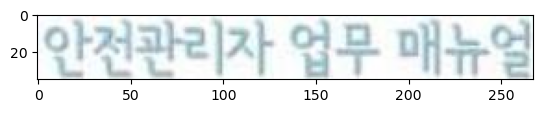

Summary: 주어진 이미지는 한글로 "안전관리자 업무매뉴얼"이라고 적혀있습니다. 이것은 아마도 안전 관련 업무를 수행하는 사람들을 위한 매뉴얼 표지일 것 같습니다.


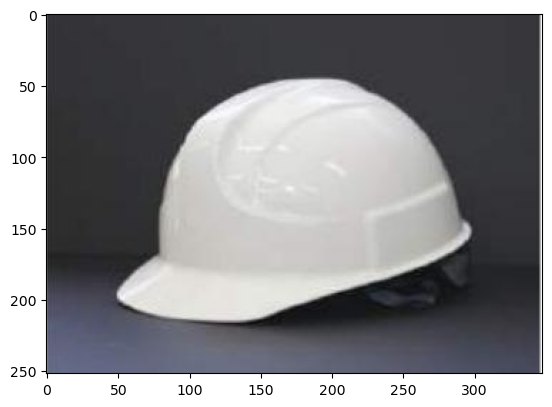

Summary: 주어진 이미지는 단순한 하얀색 안전모를 보여주고 있습니다. 안전모는 검은색 배경에 놓여있어 대비를 이루며, 작업자들이 공사 현장이나 위험한 환경에서 머리 부상을 방지하기 위해 착용하는 일반적인 모습입니다.


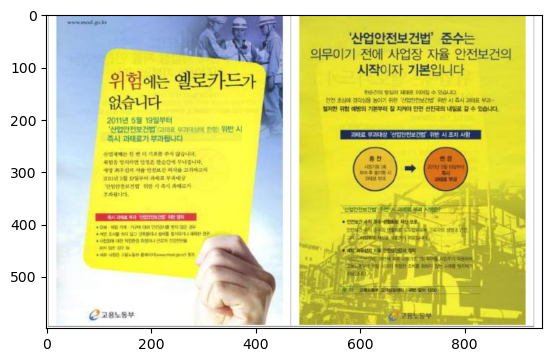

Summary: 이미지는 한국노동부에서 실시하는 '산업안전보건법' 준수 캠페인에 대한 홍보 자료입니다. 왼쪽 이미지는 작업장 안전을 강조하며 험한 근무 환경에서 얼마나 위험할 수 있는지 경고하고 있습니다. 오른쪽 이미지는 산업안전보건법의 시행 절차와 목적을 설명하고 있으며, 사업장 내 위험 요소를 제거하여 안전한 근무 환경을 조성하는 것이 중요함을 알리고 있습니다.


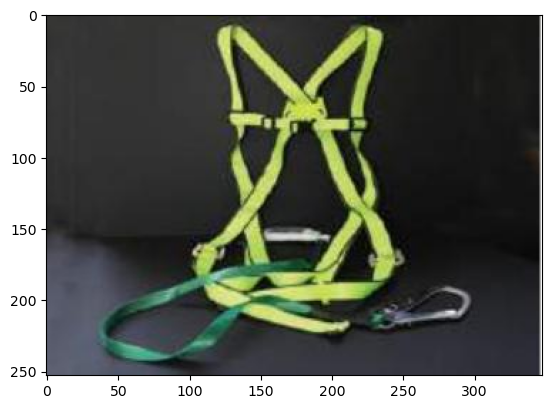

Summary: 주어진 이미지는 형광 녹색 색상의 안전 하네스를 보여줍니다. 하네스는 가슴과 등을 가로질러 교차하는 스트랩으로 구성되어 있으며, 클립이나 버클로 조절할 수 있습니다. 작업자의 안전을 위해 높은 곳에서 작업할 때 착용하는 보호 장비입니다. 하네스 옆에는 별도의 안전 로프나 걸이 부착물이 있어 추가적인 보호 기능을 제공합니다.


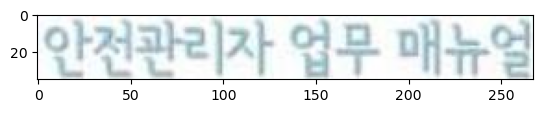

Summary: 이미지에는 한국 문화재청의 한양도성 세계유산 등재 기념 표지판이 보입니다. 표지판에는 "한전린리가 읽무 매듸울"이라는 한글 문구가 새겨져 있습니다. 이 문구는 조선시대 한양도성에 관한 내용을 담고 있는 것 같습니다.


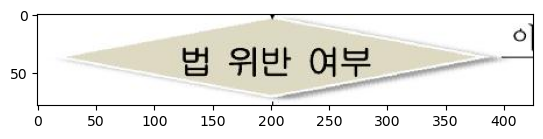

Summary: 이미지는 표지판의 모습을 담고 있습니다. 표지판에는 "밥 위반 여부"라는 한국어 문구가 적혀 있습니다. 배경은 단색으로 되어 있습니다.


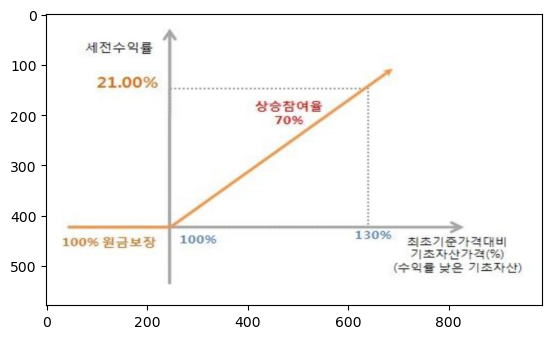

Summary: 이 이미지는 정상 작업 진행 시 100%의 원금 회복과 130%의 작업 기준 가격 대비 수익률을 보여주는 그래프입니다. 상승 곡선은 회수율이 70%일 때 21%의 서전수익률을 나타냅니다. 이는 건설 프로젝트나 사업 투자 등에서 예상되는 수익성을 시각화한 것으로 보입니다.


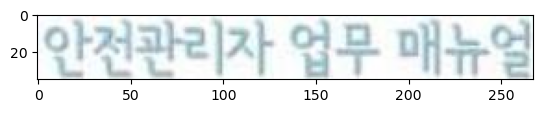

Summary: 주어진 이미지는 한국어로 "안전관리자 업무 매뉴얼"이라는 제목의 문서로 보입니다. 이는 아마도 안전 관련 업무를 수행하는 사람들을 위한 지침서나 매뉴얼일 것 같습니다.


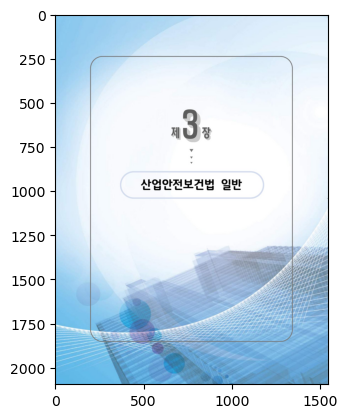

Summary: 이미지에는 제3장 타이틀과 "산업안전보건법 일반"이라는 소제목이 표시되어 있습니다. 배경에는 아름다운 산과 건물 실루엣이 있습니다. 이 이미지는 교육 자료의 한 장면으로 보입니다.


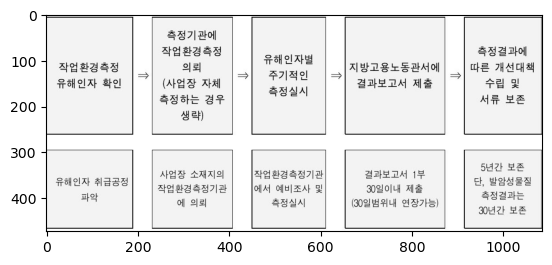

Summary: 이미지는 자연환경 속에서 유해인자 발생에서부터 인체 노출까지의 과정을 단계별로 설명하고 있습니다. 자연환경 속에서 발생한 유해인자가 작업환경 측정 의뢰를 거쳐 유해인자별 종기점이 측정되고, 지방고용노동관서에 결과가 보고되어 개선대책 수립 및 사후 분석이 이루어지는 절차를 보여주고 있습니다.


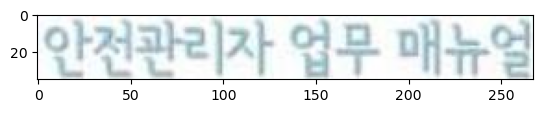

Summary: 주어진 이미지는 한국어 문구인 "안전관리자 업무 매뉴얼"이 적혀 있는 것으로 보입니다. 이는 아마도 안전 관련 매뉴얼이나 지침서의 표지일 것으로 추측됩니다. 이미지만으로는 자세한 내용을 알 수는 없지만, 산업 현장이나 작업장에서 안전 수칙을 준수하는 데 활용되는 자료일 것으로 생각됩니다.


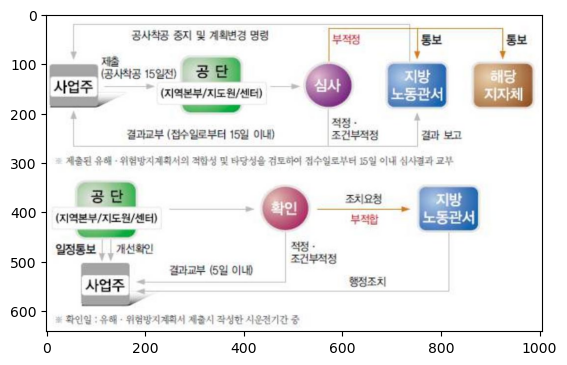

Summary: 이 이미지는 공단과 실사, 지방 노동관서, 통보, 행정 조치의 흐름을 보여주는 프로세스 다이어그램입니다. 상단 부분은 사업주가 공단에 지정된 기간 내에 경과 과정을 거치면서 지방 노동관서로 통보하고, 행정 조치로 이어지는 과정을 설명하고 있습니다. 하단 부분은 사업주가 일정 기간 내에 공단에 신고하면 확인 후 지방 노동관서로 통보되고 행정 조치로 연결되는 프로세스를 보여줍니다.


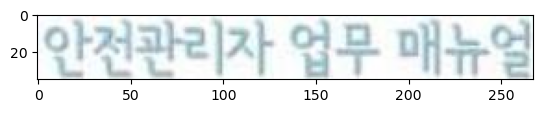

Summary: 이미지는 한국어로 '안전관리자 업무 메뉴얼'이라는 문구가 적혀있는 것으로 보입니다. 이는 아마도 한 기관이나 단체의 안전 관리 지침서나 규정집일 것으로 추측됩니다. 단순한 텍스트 이미지이지만 해당 기관의 안전 관리 체계를 나타내는 중요한 문서임을 알 수 있습니다.


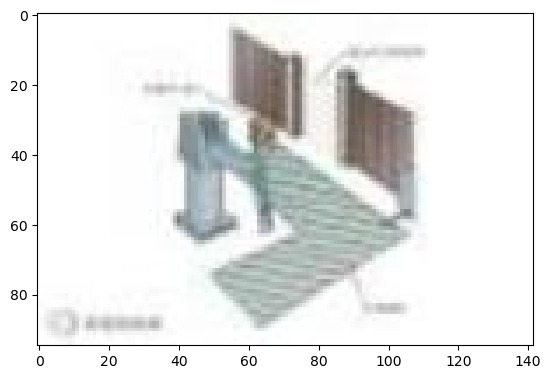

Summary: 주어진 이미지는 건물의 구조와 외벽 시스템을 보여주는 3차원 다이어그램입니다. 전면과 측면에서 본 건물의 단면도를 나타내며, 외벽에 사용된 패널의 배열과 구조적 세부 사항을 자세히 묘사하고 있습니다. 이 다이어그램은 건축 설계 및 시공 과정에서 외벽 시스템의 구체적인 계획과 이해를 돕기 위한 것으로 보입니다.


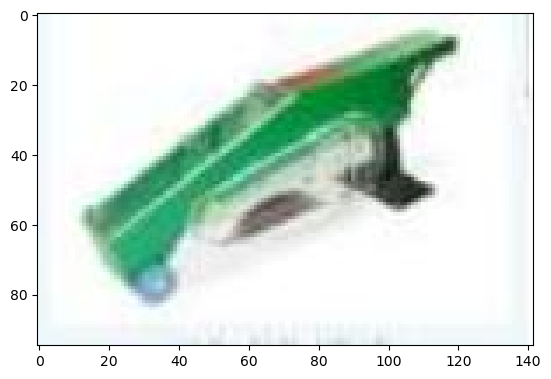

Summary: 이미지는 녹색 플라스틱으로 만든 장난감 총의 모습을 보여줍니다. 총신과 손잡이 부분이 있으며, 아이들의 장난감으로 보입니다. 단순한 디자인이지만 총기 모양을 흉내내고 있습니다.


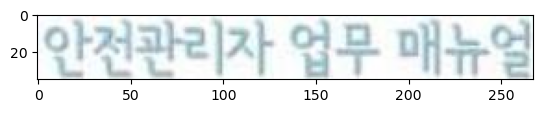

Summary: 주어진 이미지는 한국어 문구 "안전관리자 업무 매뉴얼"이 적혀 있는 책자나 문서의 표지 또는 제목을 보여주고 있습니다. 이 문서는 아마도 안전 관리자들이 업무를 수행하는 데 필요한 지침이나 절차를 상세히 설명하고 있을 것입니다.


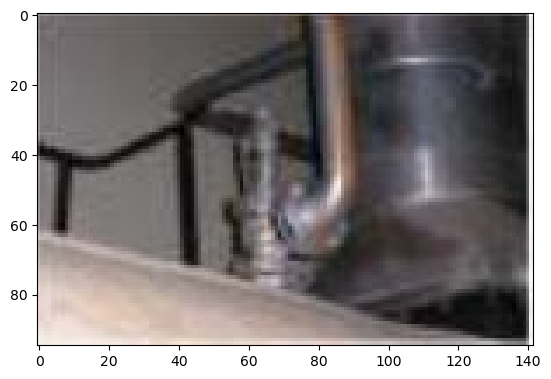

Summary: 이 이미지는 바닥에 열리고 자갈이 쌓여 있는 난방용 통풍구를 보여주고 있습니다. 진한 회색 금속 통풍구 옆으로 오래된 비닐 호스가 연결되어 있는 모습을 볼 수 있습니다. 통풍구와 호스는 지하실이나 난방 시스템의 일부분으로 보입니다. 이 장면은 오래된 건물의 보일러실이나 기계실 내부 같은 곳의 전형적인 모습입니다.


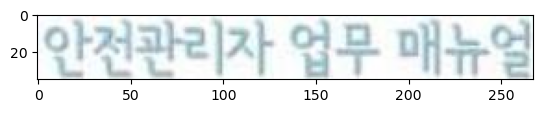

Summary: 이미지는 한국어로 "안전관리자 업무 매뉴얼"이라는 제목의 문서 표지를 보여주고 있습니다. 제목 아래에는 문서의 내용을 다룰 것임을 시사하는 아이콘들이 있습니다.


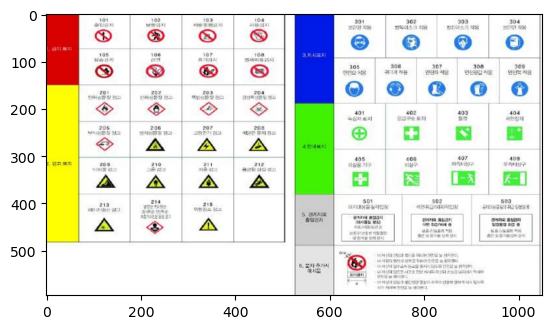

Summary: 이 이미지는 안전 표지판과 관련된 다양한 기호와 픽토그램을 보여주고 있습니다. 빨간색, 노란색, 파란색, 녹색 등 여러 가지 색상으로 구분되어 있으며, 금지 표시, 경고 표시, 행동 지시 표시 등을 포함하고 있습니다. 이러한 안전 기호는 화재, 유해 물질, 긴급 상황 등 다양한 위험 상황에서 안전을 위해 사용됩니다. 전체적으로 안전과 관련된 중요한 정보를 시각적으로 전달하는 데 목적이 있습니다.


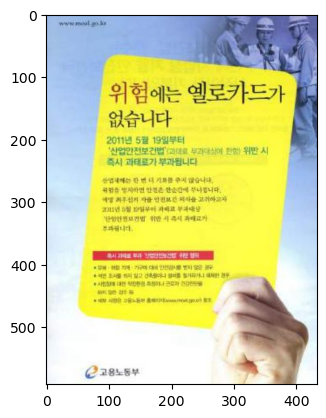

Summary: 이미지는 2019년 5월 13일부터 금연구역 확대를 알리는 광고입니다. 노란색 배경에 "의협에는 엄묵키드가 없습니다"라는 문구와 함께 금연구역 확대 내용이 적혔습니다. 또한 손으로 이미지를 잡고 있는 모습이 보입니다. 이 광고를 통해 금연 정책 강화를 홍보하고 있습니다.


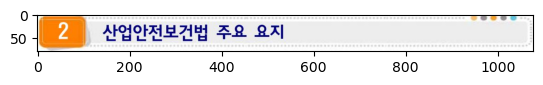

Summary: 이 이미지는 주황색 배경에 "2. 산업인적보건법 주요 요지"라는 제목이 있습니다. 단순한 문구이지만, 안전하고 건강한 작업환경의 중요성을 암시하고 있는 것 같습니다. 추가적인 세부 내용이나 정보는 제공되지 않았지만, 이 제목은 이어지는 내용이 산업 현장의 인적 보건과 관련된 법규나 지침을 다룰 것임을 시사합니다.


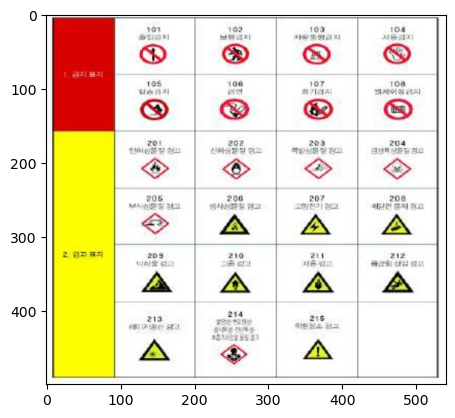

Summary: 이 이미지는 화물 운송 시 위험 물질의 종류를 나타내는 국제 규정 표지판들을 보여주고 있습니다. 상단의 붉은색 표지는 화재 위험성, 노란색 표지는 반응성 위험, 녹색 표지는 무해성 물질을 각각 의미합니다. 여러 가지 픽토그램과 숫자 코드를 통해 세부 위험 유형을 구분하고 있습니다. 이 표지판들은 화물 취급 시 안전을 위해 국제적으로 통용되는 시각 경고 체계입니다.


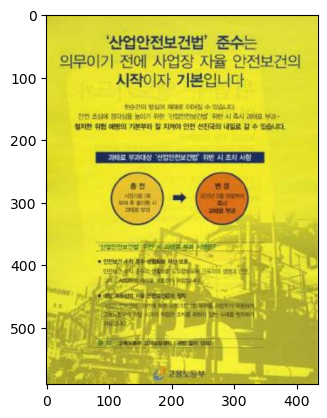

Summary: 이 이미지는 '산업안전보건법'의 주요 내용을 설명하고 있습니다. 노무자의 안전과 건강을 위해 사업장에서 지켜야 할 사항들을 구체적으로 제시하고 있습니다. 구체적인 절차로는 위험성 평가를 통해 유해·위험 요인을 파악하고, 이를 제거하거나 대책을 수립하는 과정을 거치게 됩니다. 이를 통해 노무자의 안전과 건강을 지키는 것이 목표인 것으로 보입니다.


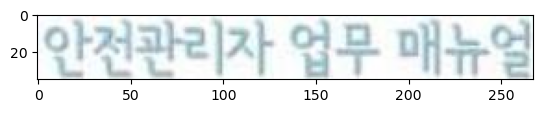

Summary: 주어진 이미지는 한국어로 "안전관리자 입구 에누리"라는 문구가 적혀있는 간판 사진입니다. 하늘색 바탕에 흰색 글씨로 되어 있으며, 직사각형 모양의 단순한 디자인입니다. 이 간판은 아마도 건물 입구 근처나 안전 관련 지역에 설치된 것으로 보입니다.


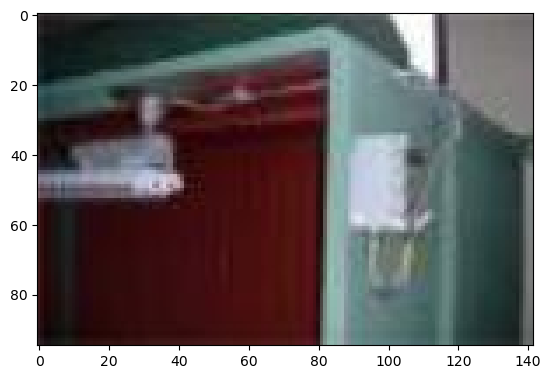

Summary: 주황색과 회색 금속 재질의 우체통이 보입니다. 우체통 옆에는 광고판이 있고, 우체통 앞에는 적색과 흰색 선이 지나가고 있습니다. 이 이미지는 도시 거리의 한 장면을 포착한 것으로 보입니다.


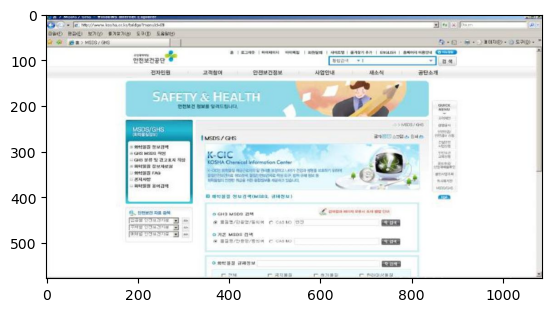

Summary: 주어진 이미지는 한국화학물질안전원(KCIC)의 웹사이트 화면을 보여주고 있습니다. 상단에는 메뉴 바가 있고, 중앙에는 안전 및 보건(Safety & Health) 섹션이 있습니다. 이 섹션에는 MSDS/GHS 정보와 K-CIC(Korea Chemical Information Center)에 대한 설명이 있습니다. 하단에는 MSDS, GHS MSDS 검색 창과 화학물질 정보 검색 옵션이 있습니다. 전반적으로 화학물질 안전 정보를 제공하는 웹사이트의 메인 페이지로 보입니다.


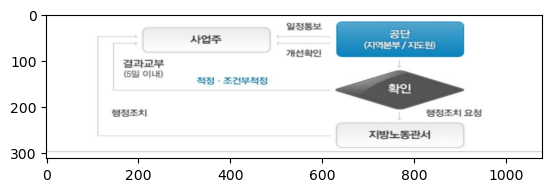

Summary: 이 이미지는 건강보험 진료 절차를 설명하는 간단한 흐름도입니다. 먼저 개인이 의료기관을 방문하면 건강보험증을 제시하고 병력조사를 거칩니다. 그 다음 진료를 받게 되며, 이때 본인부담금이 발생할 수 있습니다. 진료 후에는 지급통관서를 발급받아 비용을 정산하는 과정을 거치게 됩니다. 전체적으로 진료 절차의 주요 단계들을 명확하게 보여주고 있습니다.


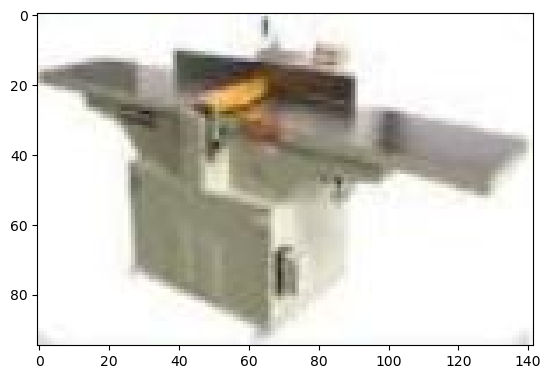

Summary: 주어진 이미지는 목재 작업용 기계인 목재 조인터를 보여줍니다. 이 기계는 나무판을 원활하게 이어 붙이고 가공하는 데 사용됩니다. 견고한 금속 프레임과 날카로운 날이 달린 회전 날개가 있어 나무를 정확하게 자르고 가공할 수 있습니다. 작업대 위에는 가공된 나무 조각이 놓여 있습니다.


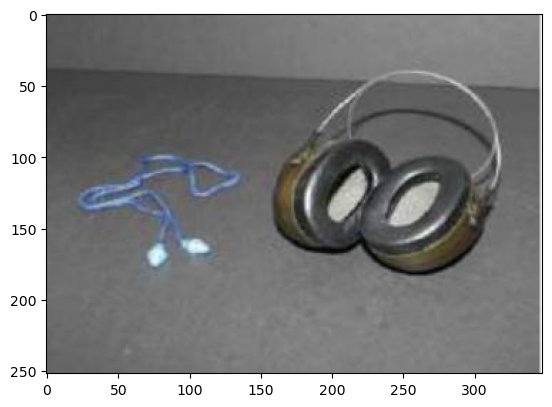

Summary: 이미지에는 회색 배경 위에 파란색 이어버드와 녹색 헤드폰이 놓여 있습니다. 이 물건들은 음악 감상이나 통화 등에 사용되는 오디오 기기로 보입니다. 이어버드는 작고 휴대가 간편한 반면, 헤드폰은 더 큰 사이즈지만 음질이 좋을 것으로 예상됩니다. 간단하고 실용적인 오디오 기기들이 담겨 있는 정물 사진입니다.


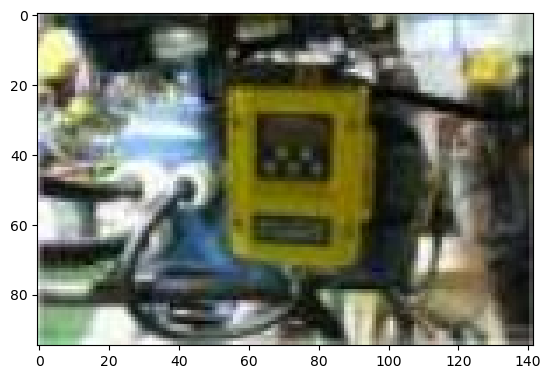

Summary: 주유소에서 사용되는 주유기 장비의 모습입니다. 노란색 본체에 호스와 노즐이 연결되어 있고, 디지털 디스플레이 화면이 있어 금액과 주유량 등의 정보를 표시합니다. 주유기 앞면에는 석유 회사의 로고가 새겨져 있습니다. 이 장비를 통해 자동차에 연료를 주입할 수 있습니다.


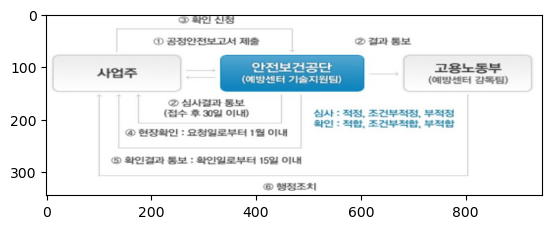

Summary: 이 이미지는 안전보건공단(예방센터 기준지침팀)의 구조를 보여주고 있습니다. 사업주로부터 시작하여 공장안전보건법 제출, 실사(직종, 주장부적격, 특직종 확인), 실적(직할, 주장부적격, 특직활) 등의 과정을 거쳐 고용노동부(예방센터 감독팀)에 이르는 절차를 나타내고 있습니다. 또한 현장확인(요청월로부터 1달 이내), 확인결과 통보(확인일로부터 15일 이내), 행정조치 등의 세부 사항도 포함되어 있습니다.


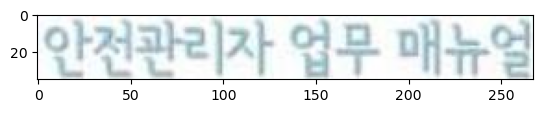

Summary: 주어진 이미지는 빨간색 바탕에 '안전 귀가 엄무 에누리'라는 한국어 문구가 흰색으로 쓰여 있습니다. 이 문구는 밤늦게 외출할 때 조심하고 안전하게 귀가할 것을 당부하는 내용으로 보입니다. 간단하면서도 안전에 대한 메시지를 전달하고 있는 이미지입니다.


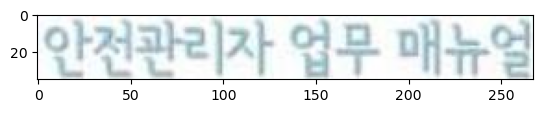

Summary: 주어진 이미지는 한글 문구 "안전관리자 업무 매뉴얼"이 적혀있는 책자의 표지 같습니다. 책자 표지의 배경은 파란색이며, 문구는 흰색으로 되어 있어 대비를 이루고 있습니다. 이 책자는 아마도 안전 관리자들을 위한 업무 지침서나 안내서일 것으로 보입니다.


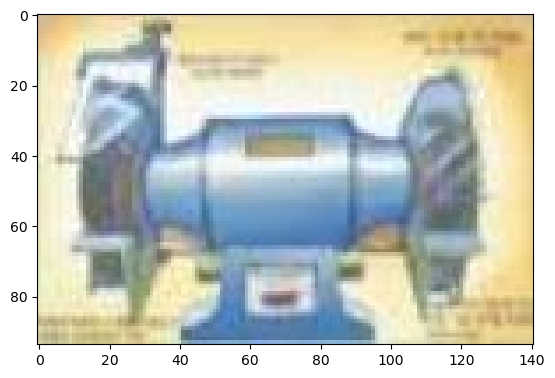

Summary: 주어진 이미지는 금속으로 된 대형 기어박스나 감속기 같은 산업용 기계 장치를 보여주고 있습니다. 이 장치는 회전 운동을 감속시키거나 토크를 증폭시키는 데 사용됩니다. 기어박스의 중앙에는 큰 기어가 있고, 양쪽으로 작은 기어들이 맞물려 있는 모습을 볼 수 있습니다. 기계의 외관은 노란색과 회색 계열의 색상으로 마감되어 있습니다.


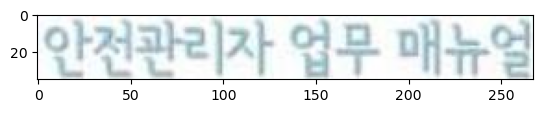

Summary: 주어진 이미지는 한국어로 "안전관리자 업무 매뉴얼"이라는 제목의 책 표지를 보여주고 있습니다. 표지는 파란색 바탕에 흰색 글씨로 제목이 적혀 있습니다.


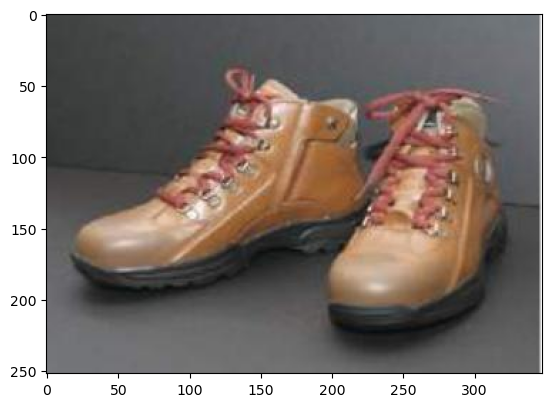

Summary: 주어진 이미지는 노란 누벅 가죽으로 된 등산화 한 켤레를 보여줍니다. 이 등산화는 발등 부분에 녹색과 빨간색 끈으로 단단히 조여져 있습니다. 바닥창은 내구성이 좋아 보이며, 아웃도어 활동에 적합한 신발로 보입니다.


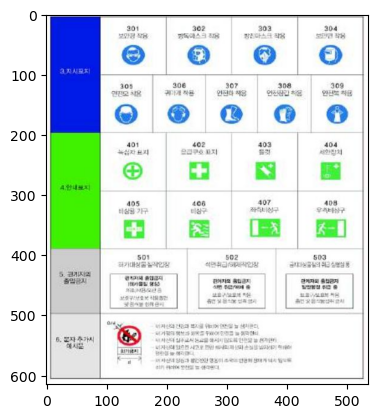

Summary: 주어진 이미지는 화재 시 안전 표지판 및 비상구 표시를 보여주는 것으로 보입니다. 위쪽 파란색 영역에는 화재 경보 및 피난 관련 표지판이 있고, 녹색 영역에는 응급 처치 및 대피로 표시가 있습니다. 아래쪽에는 화재 시 행동 요령과 금지 사항 등이 제시되어 있습니다. 이 안내판은 화재 발생 시 신속하고 안전한 대피를 위한 중요한 정보를 제공하고 있습니다.


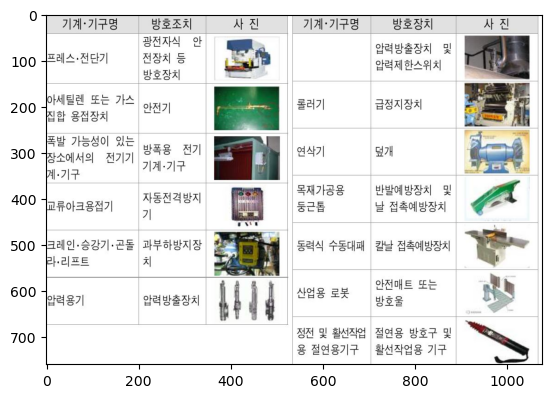

Summary: 이 이미지는 안전작업장에서 사용되는 다양한 기계, 기구, 공구, 보호장비 등을 보여주는 표입니다. 포렉스 전단기, 압력 밸브, 안전메트, 날카로운 공구 등 여러 가지 제품이 각 범주별로 구분되어 있습니다. 이 표를 통해 작업장에서 사용되는 다양한 도구와 장비를 한눈에 파악할 수 있습니다.


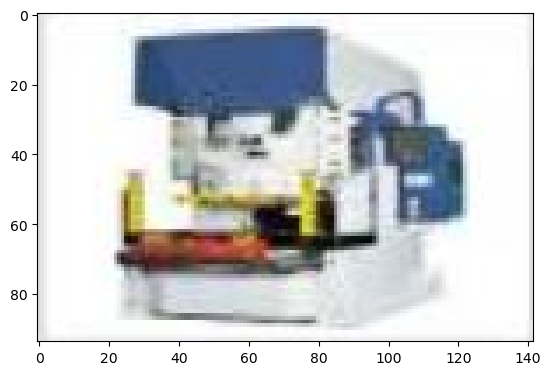

Summary: 이미지는 상자 모양의 작은 가전제품을 보여주고 있습니다. 제품 본체는 흰색과 파란색으로 구성되어 있으며, 바닥과 상단 덮개가 분리되어 있습니다. 전면에는 작은 디스플레이 화면이 있고, 측면에는 버튼이 있는 것으로 보입니다. 전반적인 디자인으로 봤을 때 소형 제빵기나 커피머신 같은 주방가전제품일 것으로 추측됩니다.


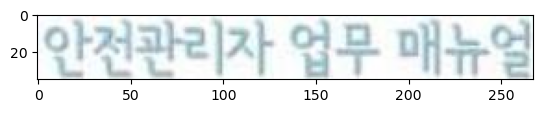

Summary: 이미지는 한국어로 '안전관리자 업무 매뉴얼'이라는 문구가 적힌 책자의 표지를 보여줍니다. 책자 표지는 밝은 녹색 바탕에 검은색 글씨로 제목이 쓰여 있습니다. 간단하고 명료한 디자인으로, 안전 관련 업무 지침서의 표지로 보입니다.


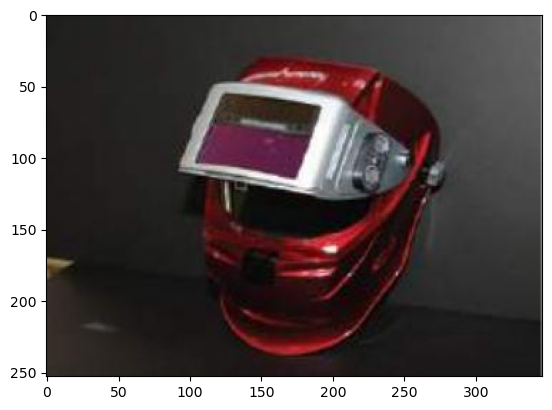

Summary: 이미지는 적색 용접 안면 가리개를 보여줍니다. 가리개에는 용접 렌즈 부분이 있어 작업 중에 눈을 보호할 수 있습니다. 용접 작업 시 불꽃과 열로부터 얼굴을 보호하는 안전 장비입니다. 단단하고 내구성 있는 소재로 제작되었으며, 어두운 배경에 대비되어 화려한 붉은색 색상이 돋보입니다.


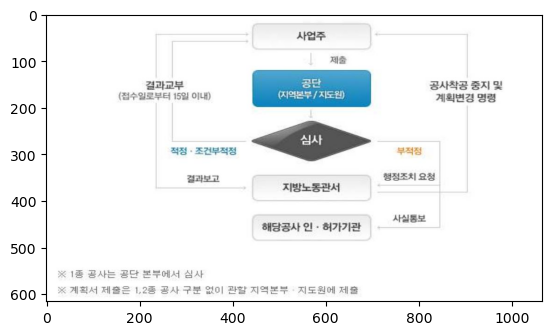

Summary: 이미지는 사업주를 중심으로 경락교부, 공단(자원분담/자도입), 공사착공 중지 및 계획변경 영향, 지방노동관서, 해당공사 인·허가관 등의 다양한 요소들이 상호 연결된 구조를 보여주고 있습니다. 이를 통해 사업의 전체적인 절차와 관련 기관들의 역할을 한눈에 파악할 수 있습니다.


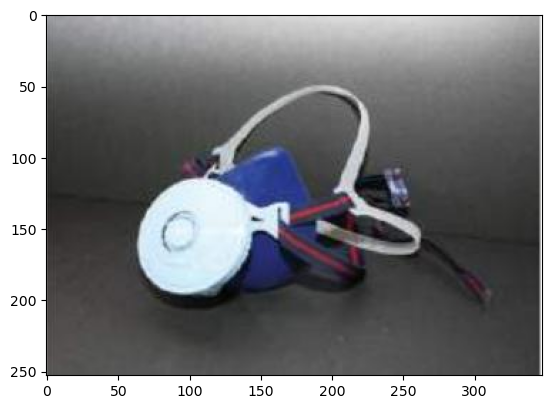

Summary: 주어진 이미지는 검은 배경 위에 컴퓨터 부품들이 놓여 있습니다. 케이블과 디스크 드라이브 등의 하드웨어 부품들이 보입니다. 이는 컴퓨터의 내부 구성요소를 보여주는 것으로 보입니다.


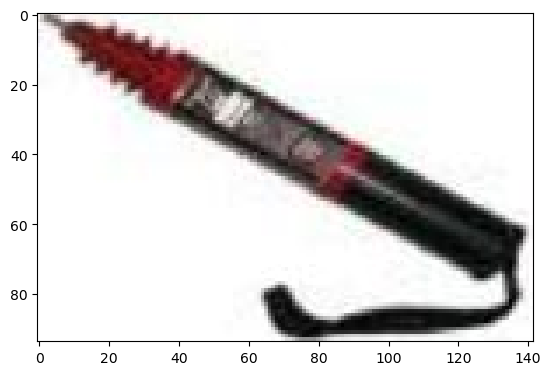

Summary: 이미지는 빨간색 우산 모양의 접이식 방풍 우산을 보여주고 있습니다. 이 우산은 비바람을 막아주는 기능뿐만 아니라 지팡이처럼 사용할 수 있는 편리한 디자인을 갖추고 있습니다. 작고 가벼워서 휴대하기 편리하며, 안전을 위해 손잡이가 달려 있습니다.


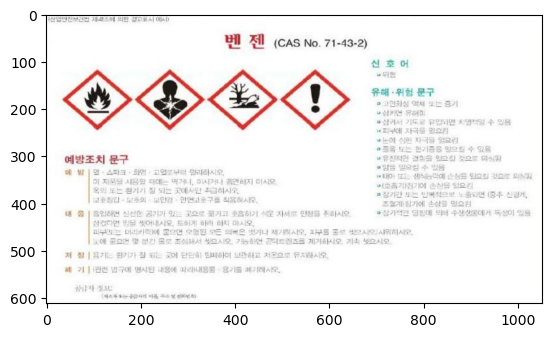

Summary: 이 이미지는 화학 물질의 취급과 관련된 안전 경고 및 예방조치 문구를 포함하고 있습니다. 화재, 건강 유해성, 환경 유해성 등의 위험 문구와 함께 해당 물질의 유해성, 위험성, 취급 주의사항을 설명하고 있습니다. 화학 물질 관리 및 안전한 취급을 위한 중요한 정보를 제공하고 있습니다.


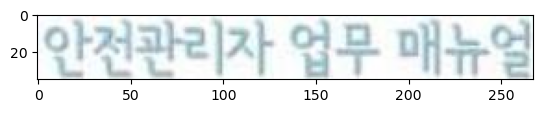

Summary: 이미지는 한글로 "안전관리자 업무 매뉴얼"이라는 제목의 문서 표지를 보여주고 있습니다. 파란색과 흰색으로 디자인되어 있으며 간단한 문양이 있습니다. 이 매뉴얼은 아마도 안전관리자의 역할과 업무 지침을 설명하고 있을 것으로 보입니다.


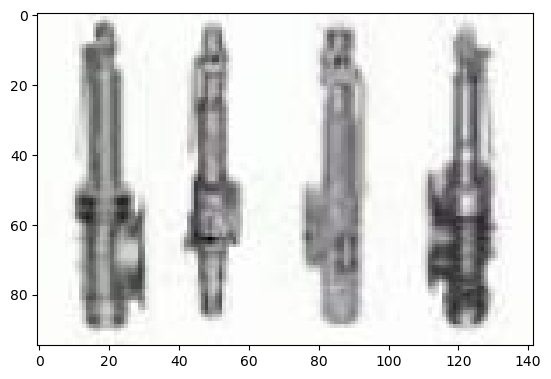

Summary: 주어진 이미지는 4개의 금속 가공 절삭 공구를 나타냅니다. 작업 환경에서 사용되는 드릴 비트, 엔드밀, 탭 등의 공구들이 보입니다. 이러한 공구들은 금속 가공 작업에 필수적인 요소입니다. 서로 다른 모양과 크기의 공구들이 각기 다른 용도로 사용되고 있습니다.


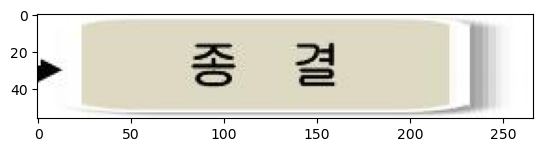

Summary: 주어진 이미지는 종결이라는 한국어 단어가 적힌 책갈피를 보여주고 있습니다. 책갈피는 베이지색 바탕에 검은색 한글 글씨로 '종결'이라고 쓰여 있습니다. 이 간단한 책갈피는 독서나 학습 등의 상황에서 특정 페이지를 표시하거나 기념하기 위해 사용될 수 있습니다.


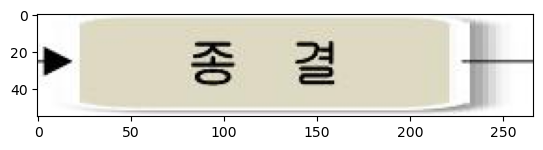

Summary: 주어진 이미지는 한국어로 '종결'이라는 문구가 새겨진 베이지색 바탕의 간단한 사인이나 표지판으로 보입니다. 읽기 쉬운 명료한 서체와 단순한 디자인으로 구성되어 있습니다.


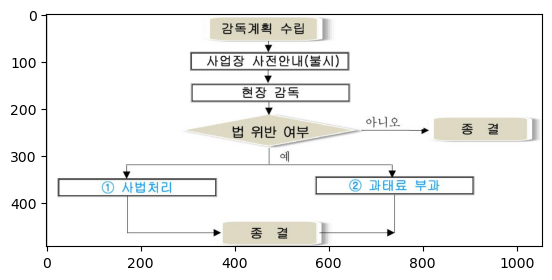

Summary: 이 이미지는 감독계획 수립에서부터 사업장 사전안내, 점장 감독, 법 위반 여부 판단, 그리고 결과에 이르는 과정을 나타내는 흐름도입니다. 사업주리와 과태료 부과라는 두 가지 결과를 보여주고 있습니다.


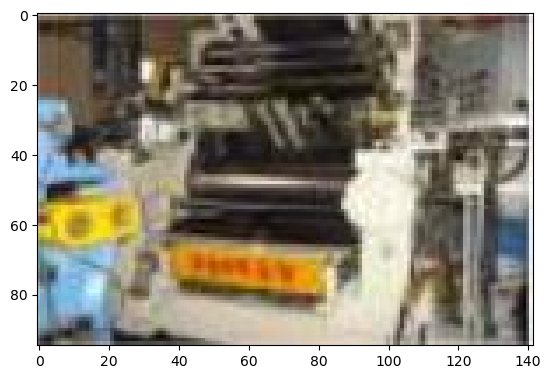

Summary: 이미지는 작업장 또는 공장 내부를 보여주고 있습니다. 중앙에는 기계 장비가 있고, 바닥에는 작업용 도구들이 놓여 있습니다. 작업장 전체적으로 정리되지 않은 모습이며, 작업 중인 모습을 담은 것으로 보입니다. 작업자들의 모습은 없지만, 작업 환경의 전반적인 분위기를 엿볼 수 있습니다.


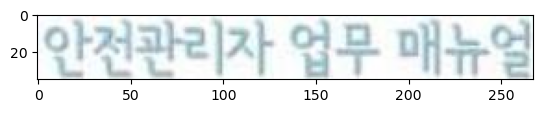

Summary: 주어진 이미지는 한글 문구 "안전귀가자 얼굴 메뉴얼"이라고 적혀있습니다. 이를 통해 안전하게 귀가하는 방법에 대한 지침이나 메뉴얼을 다룬 자료일 것으로 추측됩니다. 이미지 자체로는 구체적인 내용을 파악하기는 어렵습니다.


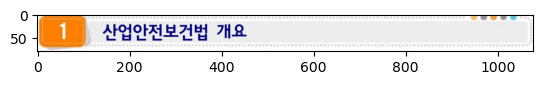

Summary: 이미지는 오렌지색 배경에 보라색 글씨로 "산업인적보건법 개요"라고 적혀있습니다. 이 제목은 해당 법에 대한 개요나 설명이 뒤에 이어질 것임을 시사합니다. 전체적으로 간단하고 명료한 제목 슬라이드로 보입니다.


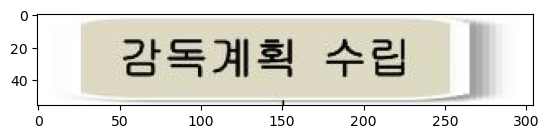

Summary: 제공된 이미지는 한국어로 "감독재획 수립"이라고 쓰여진 종이스티커를 보여주고 있습니다. 이 문구는 일반적으로 프로젝트나 업무 계획 수립 과정을 의미하는 것으로 보입니다. 이미지 자체는 단순하지만, 주요 내용을 간략하게 전달하고 있습니다.


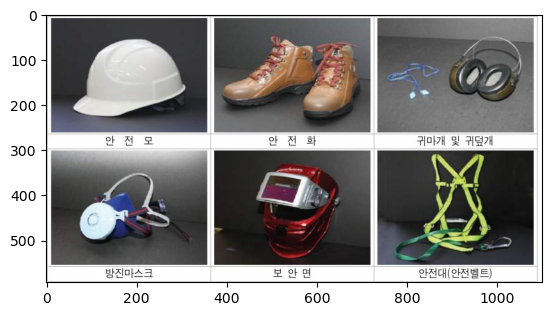

Summary: 이 이미지들은 작업 현장에서 사용되는 다양한 안전 장비들을 보여주고 있습니다. 안전모, 작업화, 보안경, 방진마스크, 용접면, 안전대 등이 포함되어 있습니다. 이러한 장비들은 작업자들의 신체적 안전을 보호하고 부상 위험을 줄이기 위해 필수적입니다.


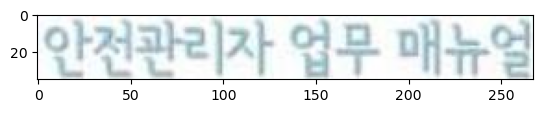

Summary: 주어진 이미지는 한글 문구 "안전관리자 업무 매뉴얼"이 적혀있는 표지 또는 타이틀 페이지로 보입니다. 이는 아마도 안전 관리와 관련된 직무 지침서나 교육 자료의 일부일 것 같습니다.


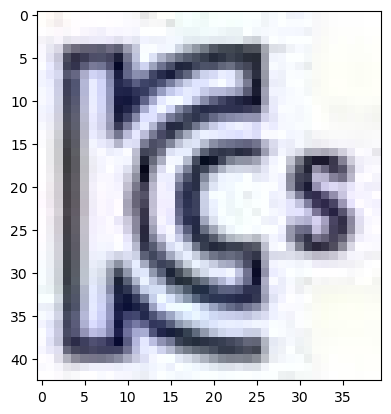

Summary: 제공된 이미지는 회사 또는 기관의 로고로 보입니다. 이 로고는 알파벳 K와 C를 결합한 형태로, 새의 머리 모양을 연상케 합니다. 로고의 전반적인 모양은 곡선과 직선이 조화롭게 어우러져 있으며, 파란색과 회색 톤의 색상을 사용하고 있습니다. 전체적으로 현대적이고 세련된 느낌을 줍니다.


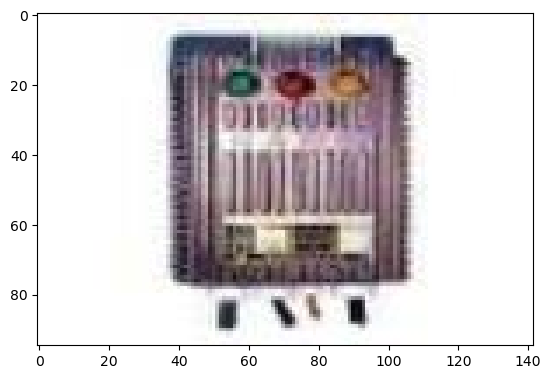

Summary: 주어진 이미지는 실외에 설치된 작은 전기 분전반 패널의 모습입니다. 금속 상자에 여러 개의 차단기와 배선이 보이며, 케이블들이 조밀하게 연결되어 있습니다. 패널 외부에는 노란색 주의 스티커가 부착되어 있어 전기 안전을 알리고 있습니다. 간단하고 견고한 디자인으로 실외 환경에서 전력을 분배하는 역할을 하는 것으로 보입니다.


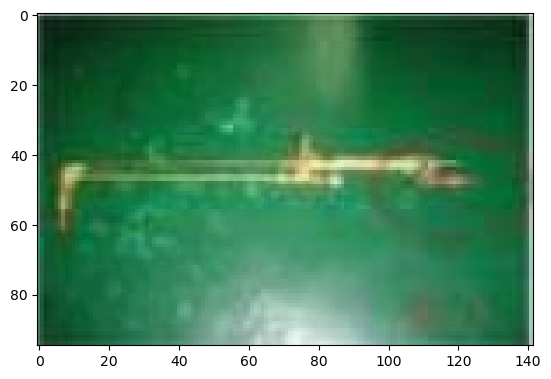

Summary: 주어진 이미지는 녹색 배경에 오래된 활과 화살촉 한 개가 놓여있는 모습입니다. 활은 나무로 만들어졌고 부드러운 곡선을 이루고 있습니다. 화살촉은 금속으로 만들어져 있고 날카로운 모습입니다. 이 이미지는 전통적인 무기나 사냥 도구를 연상시킵니다.


In [246]:
verbose = True
if verbose:
    for img_base64, summary in zip(img_info, image_summaries):
        
        print ("============================")
        img = Image.open(BytesIO(base64.b64decode(img_base64)))
        plt.imshow(img)
        plt.show()
        
        print (f'Summary: {summary}')

`요약`된 내용을 Document의 `page_content`로, `OCR`결과는 metadata의 `origin_image`로 사용

In [282]:
images_preprocessed = []

for img_path, image_base64, summary in zip(image_files, img_info, image_summaries):
    
    metadata = {}
    metadata["img_path"] = img_path
    metadata["category"] = "Image"
    metadata["image_base64"] = image_base64
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

In [249]:
# images_preprocessed = []

# for origin, summary in zip(images, image_summaries):
#     metadata = origin.metadata
#     metadata["origin_image"] = origin.page_content
#     doc = Document(
#         page_content=summary,
#         metadata=metadata
#     )
#     images_preprocessed.append(doc)

### For tables

In [250]:
human_prompt = [
    {
        "type": "text",
        "text": '''
                 Here is the table: <table>{table}</table>
                 Given table, give a concise summary.
                 Don't insert any XML tag such as <table> and </table> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [251]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"table": lambda x:x} | prompt | llm_text | StrOutputParser()

In [252]:
table_info = [t.page_content for t in tables]
table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})

이 표는 산업안전보건법과 관련된 법규들을 나열하고 있습니다. 산업안전보건법 본체와 더불어 시행령, 시행규칙, 산업안전보건기준에 관한 규칙, 유해·위험작업의 취업제한에 관한 규칙 등의 하위 법규가 있음을 보여주고 있습니다.이 표는 재해 발생 시 취해야 할 4단계 조치 사항을 설명하고 있습니다.

1단계는 재해 발생까지의 경과와 물적, 인적, 관리적 측면의 사실을 수집하는 것입니다. 
2단계는 재해 요인을 물적, 인적, 관리적 측면에서 파악하고, 직접 및 간접 원인을 결정합니다.
3단계는 재해 요인을 최종적으로 결정합니다. 
4단계는 근본 문제점과 재해 원인을 바탕으로 구체적인 재해 방지 계획을 수립합니다.이 표는 근로자의 직종과 고용형태에 따른 안전보건교육의 종류, 대상, 시간, 내용 등을 정리한 것입니다. 정기교육은 생산직, 사무직, 관리감독자, 일용직 근로자를 대상으로 분기 또는 연간 단위로 실시되며, 채용시와 작업환경 변경시에는 특별교육을 실시합니다. 건설업에서는 일용근로자를 대상으로 기초교육을 4시간 실시합니다. 교육내용은 산업안전보건법, 일반관리, 산업재해 예방, 유해위험작업 등에 관한 사항입니다.이 표는 안전표지의 종류와 용도, 사용장소를 분류하여 보여주고 있습니다. 금지, 경고, 지시, 안내 표지들과 그에 따른 상황별 금지, 경고 내용 및 착용해야 할 보호구를 상세히 기술하고 있습니다. 또한 비상 시 필요한 구조대, 세안장치 등의 안내 표지도 포함되어 있어 작업장 안전관리를 위한 종합적인 안내표지를 제공하고 있습니다.이 표는 금연이 요구되는 장소와 개인보호구를 착용해야 하는 위험한 장소들을 나열하고 있습니다. 화재 위험, 폭발성 물질, 유해화학물질, 방사능 물질, 전기 위험, 추락 위험, 극한 온도, 미끄러운 장소 등 다양한 위험 요인들에 대해 설명하고 있습니다. 이러한 장소에서는 담배를 피우거나 무단 출입하는 것이 금지되며, 필요한 경우 보안경이나 방독마스크 등의 개인보호구를 착용해야 합니다.이 표는 작업장에서 착용해야 하는 개인보호구, 안전시설,

In [253]:
verbose = True
if verbose:
    for table, summary in zip(table_info, table_summaries):
        
        print ("============================")
        print (f'table: {table}')
        print ("----------------------------")
        print (f'Summary: {summary}')
        

table: 산업안전보건법 ··················································································· 법 산업안전보건법 시행령 ····································································· 시행령 산업안전보건법 시행규칙 ································································· 시행규칙 산업안전보건기준에 관한 규칙 ······················································· 안전보건규칙 유해･위험작업의 취업제한에 관한 규칙 ······································· 취업제한규칙
----------------------------
Summary: 이 표는 산업안전보건법과 관련된 법규들을 나열하고 있습니다. 산업안전보건법 본체와 더불어 시행령, 시행규칙, 산업안전보건기준에 관한 규칙, 유해·위험작업의 취업제한에 관한 규칙 등의 하위 법규가 있음을 보여주고 있습니다.
table: 1 단계 사실의 확인 1. 재해발생까지의 경과를 파악 2. 물적, 인적, 관리적 면에 관한 사실을 수집 2 단계 재해요인의 파악 3. 물적, 인적, 관리적 면에서 재해요인 발견 4. 재해요인의 상관관계와 ⿓요도를 고려해 직접원인 및 3 단계 재해요인의 결정 간접원인을 결정 4 단계 계획(대책)의 수립 5. 근본적인 문제점 및 재해원인을 근거로 동종 또는 유사재해방지계획을 구체적으로 수립
----------------------------
Summary: 이 표는 재해 발생 시 취해야 할 4단계 조치 사항을 설명하고 있습니다.

1단계는 재해 발생까지의 경과와 물적, 인적, 관리적 측면의 사실을 수집하는 것입니다. 
2단계는 재해 요인을 물적, 인적, 관리적 측면에서 파악하고, 직접 및 간접 원인을 결정합니다.
3단계는 재해 요인을

`요약`된 내용을 Document의 `page_content`로, `parsed table`은 metadata의 `origin_table`로 사용

In [254]:
tables_preprocessed = []

for origin, summary in zip(tables, table_summaries):
    metadata = origin.metadata
    metadata["origin_table"] = origin.page_content
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    tables_preprocessed.append(doc)

### Text Spliter 로 청킹
참고: 검색된 문서/텍스트는 질문에 대답하기에 충분한 정보를 포함할 만큼 커야 합니다. 하지만 LLM 프롬프트에 들어갈 만큼 충분히 작습니다. <BR>
또한 임베딩 모델에는 입력 토큰 길이는 KoSimCSERobert는 512개, titanEmbedding(8,912개) 토큰으로 제한되어 있습니다. <BR>
이 사용 사례를 위해 [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/modules/indexes/text_splitters/examples/recursive_text_splitter.html)를 사용하여 500자가 겹치는 약 92자의 청크를 생성합니다.

In [255]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [256]:
chunk_size = 1024
chunk_overlap = 50

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=["\n\n", "\n", ".", " ", ""],
    length_function=len,
)

texts_preprocessed = text_splitter.split_documents(texts)
print(f"Number of documents after split and chunking={len(texts_preprocessed)}")

Number of documents after split and chunking=53


### Merge text, table and image

In [283]:
from itertools import chain

In [284]:
docs_preprocessed = list(chain(texts_preprocessed, tables_preprocessed, images_preprocessed))

## 4. Index 생성

### Index 이름 결정

In [285]:
import boto3
from utils.ssm import parameter_store

In [286]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [287]:
index_name = "kb_complex_pdf"

In [288]:
pm.put_params(
    key="opensearch_index_name",
    value=f'{index_name}',
    overwrite=True,
    enc=False
)

Parameter stored successfully.


### Index 스키마 정의

In [289]:
index_body = {
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer': {
                         'char_filter':['html_strip'],
                    'tokenizer': 'nori',
                    'filter': [
                        #'nori_number',
                        #'lowercase',
                        #'trim',
                        'my_nori_part_of_speech'
                    ],
                    'type': 'custom'
                }
            },
            'tokenizer': {
                'nori': {
                    'decompound_mode': 'mixed',
                    'discard_punctuation': 'true',
                    'type': 'nori_tokenizer'
                }
            },
            "filter": {
                "my_nori_part_of_speech": {
                    "type": "nori_part_of_speech",
                    "stoptags": [
                        "J", "XSV", "E", "IC","MAJ","NNB",
                        "SP", "SSC", "SSO",
                        "SC","SE","XSN","XSV",
                        "UNA","NA","VCP","VSV",
                        "VX"
                    ]
                }
            }
        },
        'index': {
            'knn': True,
            'knn.space_type': 'cosinesimil'  # Example space type
        }
    },
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'page_number': {'type':'long'},
                    'category': {'type':'text'},
                    'file_directory': {'type':'text'},
                    'last_modified': {'type': 'text'},
                    'type': {'type': 'keyword'},
                    'image_base64': {'type':'text'},
                    'origin_image': {'type':'text'},
                    'origin_table': {'type':'text'},
                }
            },
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}" # Replace with your vector dimension
            }
        }
    }
}


## 5. LangChain OpenSearch VectorStore 생성 
### 선수 조건

#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.

In [290]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [291]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### OpenSearch Client 생성

In [292]:
from local_utils.opensearch import opensearch_utils

In [293]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

### 오픈 서치 인덱스 생성 
- 오픈 서치에 해당 인덱스가 존재하면, 삭제 합니다. 

In [294]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

if index_exists:
    opensearch_utils.delete_index(
        os_client,
        index_name
    )

opensearch_utils.create_index(os_client, index_name, index_body)
index_info = os_client.indices.get(index=index_name)
print("Index is created")
pprint(index_info)

index_name=kb_complex_pdf, exists=True

Deleting index:
{'acknowledged': True}

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'kb_complex_pdf'}
Index is created
{'kb_complex_pdf': {'aliases': {},
                    'mappings': {'properties': {'metadata': {'properties': {'category': {'type': 'text'},
                                                                            'file_directory': {'type': 'text'},
                                                                            'image_base64': {'type': 'text'},
                                                                            'last_modified': {'type': 'text'},
                                                                            'origin_image': {'type': 'text'},
                                                                            'origin_table': {'type': 'text'},
                                                                            'page_number': {'type': 'long'},
     

### 랭체인 인덱스 연결 오브젝트 생성

- [langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html)

In [295]:
from langchain.vectorstores import OpenSearchVectorSearch

In [296]:
vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_domain_endpoint,
    embedding_function=llm_emb,
    http_auth=http_auth, # http_auth
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)
vector_db

### OpenSearch 에 문서 삽입

In [297]:
%%time

vector_db.add_documents(
    documents = docs_preprocessed, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 459 ms, sys: 13.4 ms, total: 472 ms
Wall time: 16.1 s


['491a8928-0a62-483a-88ed-bd9552e472e0',
 '40d5e591-71b7-4a4e-aaa7-b405ac460039',
 'eaa772e4-aadd-4c1c-9494-d19684e1f6a7',
 '1cec9952-f0d6-468d-8a60-af4d7a9efb81',
 'b34e1918-6665-4a3b-817e-217683eccc2b',
 'ec84123f-fe64-4b45-a62a-a434f8ac9f6c',
 '499ebcfb-5c3c-4811-a0c1-8995ec2f4c4d',
 'af69a6e8-3489-4510-92f5-8304fd5b81c0',
 'bb52def0-cff8-4a70-b91b-59be71d3f59c',
 '2c0c94d5-3645-413b-8fd8-619f298daf0a',
 'f5d76f42-d144-4c23-8c92-bfd8df5c50cb',
 '820f5265-6de3-4f52-9e43-87600355ac2f',
 '8348b300-ea15-46ee-89f3-c0e02ad8c3f8',
 '8b9608cf-a620-4f98-9049-3081652927e9',
 '40141cfe-8a59-48ee-92b2-995c311285c8',
 '695c0524-f2ff-4a62-acdb-7df92a526a8e',
 '39d50dc0-0b0b-4136-9949-241ee393906a',
 'dddd17ec-85e4-4f76-8254-46a6296f77e6',
 'bca3f0a1-a488-4b66-b7e7-8436c70b86b9',
 '2e4f4e9d-10ea-4a7a-80ed-1923fdd78451',
 '3b944b00-78f3-4fac-abd1-ec569b38c360',
 '71332f9a-fcec-4495-9a31-889931f8ab82',
 'e629bc68-5e18-4e85-a93a-25434b2f1ff7',
 '5c8be417-28e2-470a-904a-adaf780c590f',
 'c4b34f6f-5c7d-

## 6. 검색 테스트

In [302]:
from utils.rag import qa_chain_complex_pdf
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

In [303]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document = False, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_pdf=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=7, # 최종 Document 수 정의
    verbose=False,
)

### 하이브리드 검색

In [304]:
query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "만기가격이 기준가격의 80% 일 때 만기상환금액 계산하는 방법 알려줘"
query = "이 이미지는 공단 실사 및 지방 노동관서 업무 절차를 보여주는 흐름도"
#query = "그래프 설명해줘"

search_filter=[
    #{"term": {"metadata.source": "신한은행"}},
    #{"term": {"metadata.type": "인터넷뱅킹"}},
]

In [305]:
%%time
search_hybrid_result, tables, images = opensearch_hybrid_retriever.get_relevant_documents(query)
#show_context_used(search_hybrid_result)

CPU times: user 10.7 ms, sys: 8.22 ms, total: 19 ms
Wall time: 131 ms


-----------------------------------------------
1. Category: Image, Chunk: 212 Characters
-----------------------------------------------


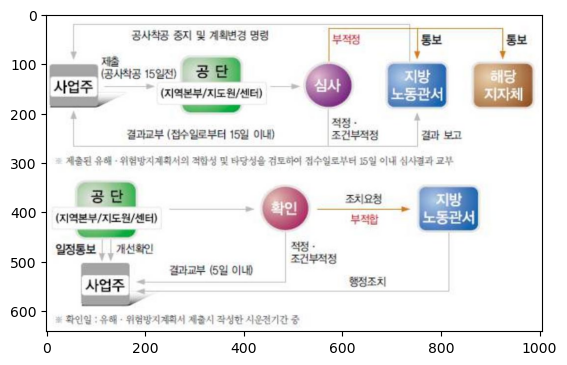

이 이미지는 공단과 실사, 지방 노동관서, 통보, 행정 조치의 흐름을 보여주는 프로세스 다이어그램입니다. 상단 부분은 사업주가 공단에 지정된 기간 내에 경과 과정을 거치면서 지방
노동관서로 통보하고, 행정 조치로 이어지는 과정을 설명하고 있습니다. 하단 부분은 사업주가 일정 기간 내에 공단에 신고하면 확인 후 지방 노동관서로 통보되고 행정 조치로 연결되는
프로세스를 보여줍니다.
metadata:
 {'img_path': './fig/figure-6-5.jpg', 'category': 'Image', 'image_base64': '', 'id':
'768683a3-16e7-48dc-85a1-fde692012c49', 'origin_image': ''}
-----------------------------------------------
2. Category: Image, Chunk: 153 Characters
-----------------------------------------------


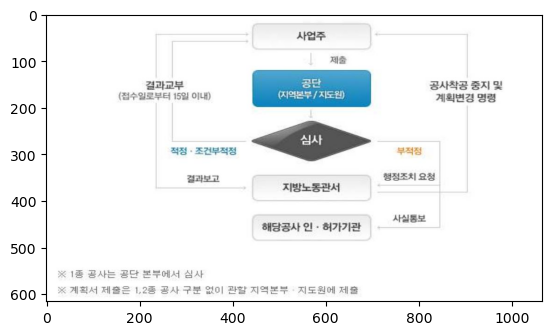

이미지는 사업주를 중심으로 경락교부, 공단(자원분담/자도입), 공사착공 중지 및 계획변경 영향, 지방노동관서, 해당공사 인·허가관 등의 다양한 요소들이 상호 연결된 구조를 보여주고
있습니다. 이를 통해 사업의 전체적인 절차와 관련 기관들의 역할을 한눈에 파악할 수 있습니다.
metadata:
 {'img_path': './fig/figure-10-15.jpg', 'category': 'Image', 'image_base64': '', 'id':
'ee708d26-49d8-4d3a-bae5-234a0e522f3f', 'origin_image': ''}
-----------------------------------------------
3. Category: CompositeElement, Chunk: 247 Characters
-----------------------------------------------
(16) 지방고용노동관서 감독 진행절차 ○ 지방고용노동관서장은 산업안전보건법 또는 이 법에 의한 명령 위반여부를 확인하기 위해 필요하다고 인정하는 경우 산업안전보건감독관으로 하여금
사업장에 출입케하여 서류 확 인 및 안전보건점검 등을 수행 후 법 위반사실이 발견된 경우 사업주에게 기계･기구설비의 사용⿓지 또는 시설의 개선 기타 안전보건 상의 필요한 조치를
명할 수 있다. (산업안전보건법 제51조, 위반시 1,000만원 이하의 과태료 부과)
metadata:
 {'source': './data/complex_pdf/text2.pdf', 'filetype': 'application/pdf', 'languages': ['eng'],
'last_modified': '2024-03-15T07:48:53', 'page_number': 30, 'file_directory': './data/complex_pdf',
'filename': 'text2.pdf', 'category': 'CompositeElement', 'id':
'53719fa2-9fb8-4e17-a1c

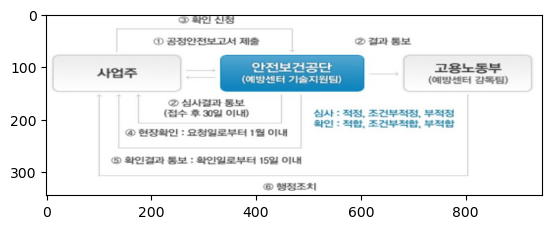

이 이미지는 안전보건공단(예방센터 기준지침팀)의 구조를 보여주고 있습니다. 사업주로부터 시작하여 공장안전보건법 제출, 실사(직종, 주장부적격, 특직종 확인), 실적(직할,
주장부적격, 특직활) 등의 과정을 거쳐 고용노동부(예방센터 감독팀)에 이르는 절차를 나타내고 있습니다. 또한 현장확인(요청월로부터 1달 이내), 확인결과 통보(확인일로부터 15일
이내), 행정조치 등의 세부 사항도 포함되어 있습니다.
metadata:
 {'img_path': './fig/figure-20-38.jpg', 'category': 'Image', 'image_base64': '', 'id':
'3459a675-19d1-4c31-8234-e44fb56146e3', 'origin_image': ''}
-----------------------------------------------
5. Category: Image, Chunk: 111 Characters
-----------------------------------------------


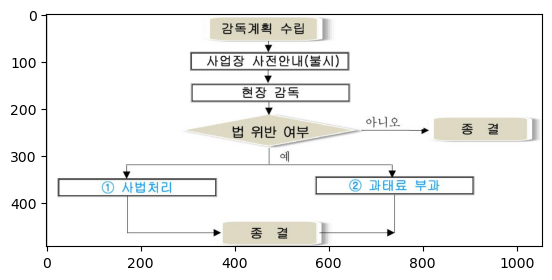

이 이미지는 감독계획 수립에서부터 사업장 사전안내, 점장 감독, 법 위반 여부 판단, 그리고 결과에 이르는 과정을 나타내는 흐름도입니다. 사업주리와 과태료 부과라는 두 가지 결과를
보여주고 있습니다.
metadata:
 {'img_path': './fig/figure-11-21.jpg', 'category': 'Image', 'image_base64': '', 'id':
'a280219f-8c9e-4926-af49-e29351f196e4', 'origin_image': ''}
-----------------------------------------------
6. Category: Image, Chunk: 193 Characters
-----------------------------------------------


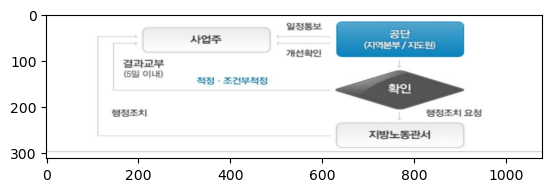

이 이미지는 건강보험 진료 절차를 설명하는 간단한 흐름도입니다. 먼저 개인이 의료기관을 방문하면 건강보험증을 제시하고 병력조사를 거칩니다. 그 다음 진료를 받게 되며, 이때
본인부담금이 발생할 수 있습니다. 진료 후에는 지급통관서를 발급받아 비용을 정산하는 과정을 거치게 됩니다. 전체적으로 진료 절차의 주요 단계들을 명확하게 보여주고 있습니다.
metadata:
 {'img_path': './fig/figure-11-27.jpg', 'category': 'Image', 'image_base64': '', 'id':
'a3a1b902-4711-4b59-a420-33464f1892c9', 'origin_image': ''}
-----------------------------------------------
7. Category: CompositeElement, Chunk: 159 Characters
-----------------------------------------------
| * 임시건강진단 : 동일 근무자와 유사한 질병증상이 발생한 경우, 직업병 유소견자가 다수 발생하 거나 우려가 있는 경우, 지방고용노동관서의 장이 필요하다고 판단하는 경우 ②
건강진단 실시기관 ○ 고용노동부장관이 지정하는 기관 또는 ｢국민건강보험법｣에 따른 검진기관 ■ 건강진단 절차
metadata:
 {'source': './data/complex_pdf/text2.pdf', 'filetype': 'application/pdf', 'languages': ['eng'],
'last_modified': '2024-03-15T07:48:53', 'page_number': 15, 'file_directory': './data/complex_pdf',
'filename': 'text2.pdf', 'category': 'CompositeElement', 'id':
'71332f9a-fcec-4495-9a31-889931f8ab82'}


In [306]:
show_context_used(search_hybrid_result)